In [1]:
# use model as ViViT model or slowfast model
import torch
import pandas as pd
import matplotlib.pyplot as plt
from src.CustomDataset import CustomDataset
from torch.utils.data import DataLoader

In [2]:
from src.utils.utility import show_data_composition
show_data_composition("./dataset/dur21_dis0/")

########### Total Dataset Composition ########### 
disruption :  82
normal :  8166
########### Train Dataset Composition ########### 
disruption :  48
normal :  4896
########### Valid Dataset Composition ########### 
disruption :  16
normal :  1632
########### Test Dataset Composition ########### 
disruption :  18
normal :  1638


/home/zinzinbin/.conda/envs/research-env/lib/python3.9/site-packages/torchvision/transforms/_functional_video.py:5: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  warnings.warn(
/home/zinzinbin/.conda/envs/research-env/lib/python3.9/site-packages/torchvision/transforms/_transforms_video.py:25: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  warnings.warn(


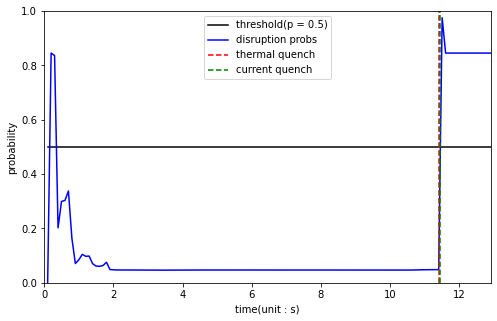

In [4]:
from src.models.ViViT import ViViT
import os

model = ViViT(
    image_size = 224,
    patch_size = 32,
    n_classes = 2,
    n_frames = 21,
    dim = 64,
    depth = 4,
    n_heads = 4,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

# torch cuda initialize and clear cache
torch.cuda.init()
torch.cuda.empty_cache()

# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:" + str(0)
else:
    device = 'cpu'

model.to(device)

model.load_state_dict(torch.load("./weights/ViViT_clip_21_dist_0_best.pt"))

from src.utils.utility import generate_prob_curve, video2tensor

shot_num = 21747
video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)

dataset = video2tensor(video_dir, 3, 21, 224, 256,256, False)
prob_list = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 64, 
    device = device, 
    save_dir = "./results/ViViT_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 21,
    dist_frame = 0,
    use_continuous_frame = False
)

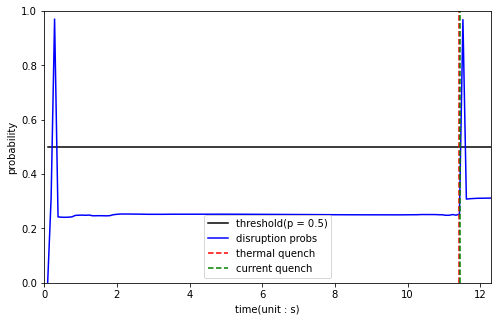

In [10]:
from src.models.slowfast import SlowFast
from src.models.resnet import Bottleneck3D

model = SlowFast(
        input_shape = (3, 20, 224, 224),
        block = Bottleneck3D,
        layers = [1,2,2,1],
        alpha = 4,
        tau_fast = 1,
        mlp_hidden = 64,
        num_classes = 2,
        device = device
)

model.to(device)
model.load_state_dict(torch.load("./weights/slowfast_clip_21_dist_0_best.pt"))

dataset = video2tensor(video_dir, 3, 20, 224, 256,256, False)
prob_list = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 64, 
    device = device, 
    save_dir = "./results/slowfast_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 20,
    dist_frame = 0,
    use_continuous_frame = False
)